In [1]:
from textblob import TextBlob  #用於情感分析
from bs4 import BeautifulSoup #用來爬取資料
import requests #用來爬取資料
from collections import Counter
import nltk #自然語言分析
from nltk.corpus import stopwords #取得英文的停用詞(口綴詞)
from nltk.stem import WordNetLemmatizer #詞形還原
from nltk.tokenize import word_tokenize #分詞
import matplotlib.pyplot as plt
from wordcloud import WordCloud #文字詞雲
import jieba #中文分詞
from googletrans import Translator #文字翻譯
import pandas as pd
from newsapi import NewsApiClient #新聞API newsapi_python
import seaborn as sns
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/frank/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/frank/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/frank/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#需要先到該網站註冊，取得api key
api = NewsApiClient(api_key='**********************') #填入自己的api key

#使用dataframe存放收集的英文新聞
df_en = pd.DataFrame([])

#設定新聞關鍵字
key_words = [
    "Houston Consulate",
    "China's Houston Consulate",
    "Chinese Consulate Houston"]
for key_word in key_words:
    result_en = api.get_everything(q=key_word, page_size=100)
    result_en_df = pd.DataFrame(result_en)
    print(df_en.shape)
    if df_en.shape[0] == 0:
        df_en = result_en_df
    else:
        df_en = pd.concat([df_en, result_en_df], axis=0, ignore_index=True)

#只留下內容部分
articles_en_df = pd.DataFrame(df_en['articles'].to_dict()).T
print(articles_en_df.head(1))

#去除重複內容
articles_en_df.drop_duplicates(subset='url', keep='first', inplace=True)

print(f'查詢的新聞數量：{articles_en_df.shape[0]}')

(0, 0)
(100, 3)
(200, 3)
                                   source                            author  \
0  {'id': 'bbc-news', 'name': 'BBC News'}  https://www.facebook.com/bbcnews   

                                               title  \
0  US diplomats to leave consulate in Chengdu in ...   

                                         description  \
0  China's decision to close the US mission came ...   

                                                 url  \
0  https://www.bbc.co.uk/news/world-asia-china-53...   

                                          urlToImage           publishedAt  \
0  https://ichef.bbci.co.uk/news/1024/branded_new...  2020-07-27T00:05:37Z   

                                             content  
0  Image copyrightEPAImage caption\r\n A man was ...  
查詢的新聞數量：180


[('US', 70), ('China', 57), ('consulate', 35), ('tension', 30), ('India', 21), ('Sino', 21), ('Houston', 20), ('Chengdu', 12), ('Chinese', 12), ('UK', 11), ('stock', 10), ('closure', 9), ('Africa', 9), ('week', 9), ('say', 8), ('dollar', 8), ('set', 7), ('Trump', 7), ('escalate', 7), ('hit', 7), ('GRAINS', 7), ('Soybeans', 7), ('MARKETS', 6), ('share', 6), ('gain', 6), ('relation', 5), ('FOREX', 5), ('high', 5), ('Yuan', 5), ('lower', 5)]


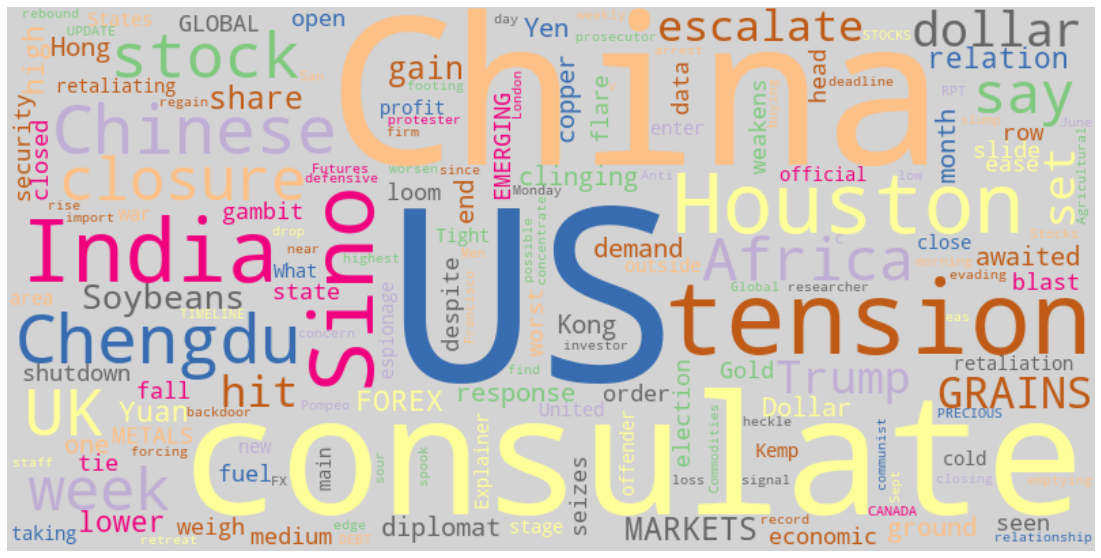

In [3]:
#清理常見縮寫
articles_en_df['title'] = articles_en_df['title'].str.replace('U.S.', 'US')
articles_en_df['title'] = articles_en_df['title'].str.replace('-', ' - ')  # !! with space
#reuters_str = articles_en_df[articles_en_df['source'] =='Reuters']['title'].str.cat(sep=" . ")  # !! with space

def get_news_source(news_source):
    return news_source.get('name')

#針對特定媒體,如路透社
reuters_str = articles_en_df[articles_en_df['source'].apply(get_news_source)=='Reuters']['title'].str.cat(sep=" . ")
reuters_all_words = word_tokenize(reuters_str)

#加入停用詞
alpha_only = [t for t in reuters_all_words if t.isalpha()]
english_stops = stopwords.words('english')

#將新聞媒體名字加入停用詞
english_stops.extend(list(articles_en_df['source'].apply(get_news_source).unique()))
no_stops = [t for t in alpha_only if t not in english_stops]
wordnet_lemmatizer = WordNetLemmatizer()
lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]
bow = Counter(lemmatized)

#顯示前30個最常出現的英文字
print(bow.most_common(30))

wordcloud_reuter = WordCloud(
    min_font_size=10,
    width=800,
    height=400,
    collocations=False,
    background_color='LightGrey',
    colormap='Accent'
)

wordcloud_reuter.fit_words(bow)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_reuter, interpolation="bilinear")
plt.axis("off")
plt.show()

(180, 9)


Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/24/v1rqqrhj2k10yz0rg7zs44xr0000gn/T/jieba.cache


[',', '?', '、', '。', '“', '”', '《', '》', '！', '，', '：', '；', '？', '人民', '末##末', '啊', '阿', '哎', '哎呀', '哎喲', '唉', '我', '我們', '按', '按照', '依照', '吧', '吧噠', '把', '罷了', '被', '本', '本著', '比', '比方', '比如', '鄙人', '彼', '彼此', '邊', '別', '別的', '別說', '並', '並且', '不比', '不成', '不單', '不但', '不獨', '不管', '不光', '不過', '不僅', '不拘', '不論', '不怕', '不然', '不如', '不特', '不惟', '不問', '不只', '朝', '朝著', '趁', '趁著', '乘', '沖', '除', '除此之外', '除非', '除了', '此', '此間', '此外', '從', '從而', '打', '待', '但', '但是', '當', '當著', '到', '得', '的', '的話', '等', '等等', '地', '第', '叮咚', '對', '對於', '多', '多少', '而', '而況', '而且', '而是', '而外', '而言', '而已', '爾後', '反過來', '反過來說', '反之', '非但', '非徒', '否則', '嘎', '嘎登', '該', '趕', '個', '各', '各個', '各位', '各種', '各自', '給', '根據', '跟', '故', '故此', '固然', '關於', '管', '歸', '果然', '果真', '過', '哈', '哈哈', '呵', '和', '何', '何處', '何況', '何時', '嘿', '哼', '哼唷', '呼哧', '乎', '嘩', '還是', '還有', '換句話說', '換言之', '或', '或是', '或者', '極了', '及', '及其', '及至', '即', '即便', '即或', '即令', '即若', '即使', '幾', '幾時', '己', '既', '既然', '既是', '繼而', '加之', '假如', '假若', '假使', '鑒於', '將', '

Loading model cost 0.685 seconds.
Prefix dict has been built succesfully.


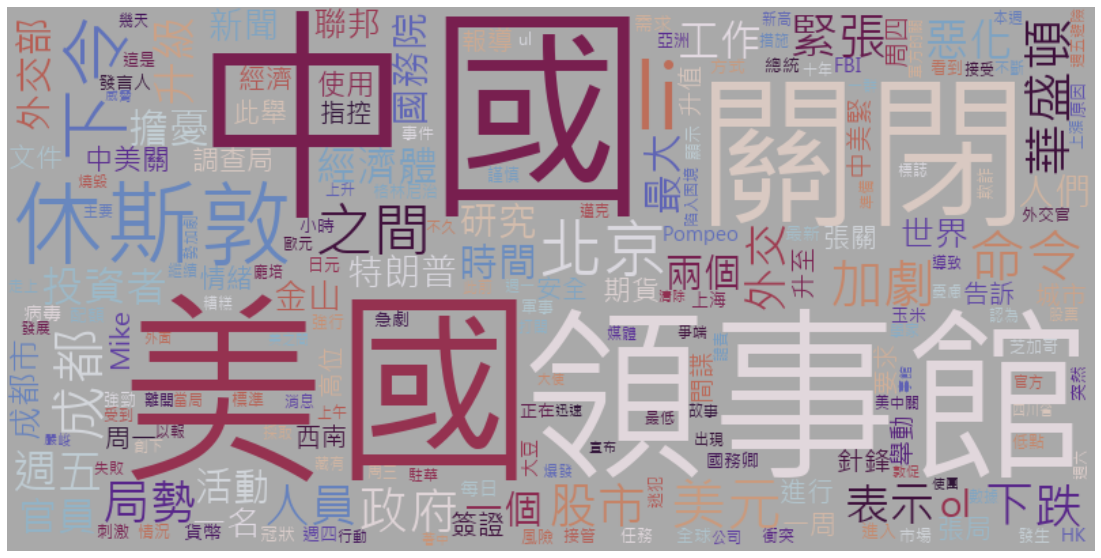

In [4]:
# 使用gogole translate將英文訊息翻譯為繁體中文訊息
translator = Translator()
def get_translated_text(translated):
    return translated.text

articles_en_df['title_TW'] = articles_en_df['title'].apply(
    translator.translate,
    src='en',
    dest='zh-tw').apply(get_translated_text).str.strip()

print(articles_en_df.shape)
articles_en_df['descr_TW'] = articles_en_df['description'].apply(
    translator.translate,
    src='en',
    dest='zh-tw').apply(get_translated_text).str.strip()


def jieba_processing_txt(text, stop_words_file):
    mywordlist = []
    seg_list = jieba.cut(text, cut_all=False)
    stopwords = [
        line.strip() for line in open(
            stop_words_file,
            encoding='utf-8').readlines()]
    print(stopwords)
    for myword in seg_list:
        if len(myword.strip()) > 1 and myword not in stopwords:
            mywordlist.append(myword)
    return ' '.join(mywordlist)

font = 'msjh.ttf'
stop_words_file = 'stop_words_tw.txt'
wordcloud_en = WordCloud(
    min_font_size=10,
    width=800,
    height=400,
    collocations=False,
    background_color='DarkGrey',
    colormap='twilight',
    font_path=font).generate(
        jieba_processing_txt(
            articles_en_df['descr_TW'].str.cat( sep='.'), stop_words_file))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_en, interpolation="bilinear")
plt.axis("off")
plt.show()

In [5]:
api = NewsApiClient(api_key='='**********************')

df_en = pd.DataFrame([])
key_words = [
    "Trump",
    "covid-19",
    "Coronavirus"
    "electon",
    "Biden",
    "polling"]

for key_word in key_words:
    result_en = api.get_everything(q=key_word, page_size=100)
    result_en_df = pd.DataFrame(result_en)
    print(df_en.shape)
    if df_en.shape[0] == 0:
        df_en = result_en_df
    else:
        df_en = pd.concat([df_en, result_en_df], axis=0, ignore_index=True)
        
articles_en_df = pd.DataFrame(df_en['articles'].to_dict()).T
print(articles_en_df.head(1))

articles_en_df.drop_duplicates(subset='url', keep='first', inplace=True)
print(f'查詢的新聞數量：{articles_en_df.shape[0]}')
print(articles_en_df.info())

(0, 0)
(100, 3)
(200, 3)
(200, 3)
(300, 3)
                                     source      author  \
0  {'id': 'the-verge', 'name': 'The Verge'}  Tom Warren   

                                               title  \
0  President Trump says he will ban TikTok in the...   

                                         description  \
0  President Trump says he will plan TikTok from ...   

                                                 url  \
0  https://www.theverge.com/2020/8/1/21350578/tik...   

                                          urlToImage           publishedAt  \
0  https://cdn.vox-cdn.com/thumbor/WoV3fOT4tjDSfE...  2020-08-01T09:19:32Z   

                                             content  
0  Ban could come via an executive order or emerg...  
查詢的新聞數量：389
<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 399
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   source       389 non-null    

[('Trump', 134), ('Biden', 82), ('Covid', 49), ('COVID', 41), ('US', 33), ('election', 32), ('India', 25), ('say', 22), ('vote', 20), ('campaign', 16), ('new', 15), ('coronavirus', 15), ('How', 14), ('The', 13), ('poll', 13), ('Joe', 12), ('Hong', 11), ('With', 10), ('voter', 10), ('back', 10), ('It', 10), ('mask', 10), ('News', 10), ('show', 9), ('Fox', 9), ('Kong', 9), ('Obama', 9), ('TikTok', 8), ('Donald', 8), ('Twitter', 8)]


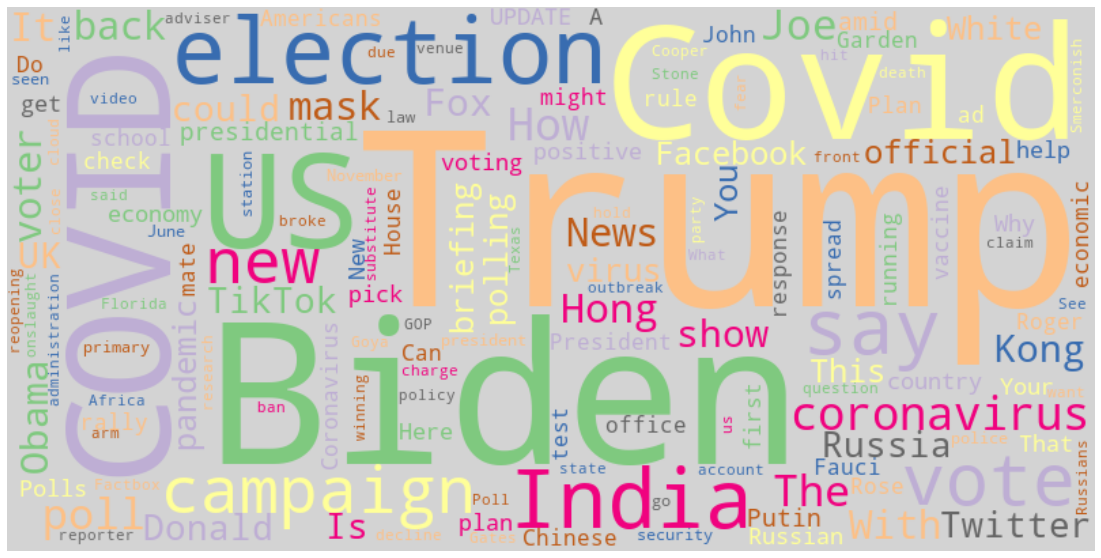

In [6]:
articles_en_df['title'] = articles_en_df['title'].str.replace('U.S.', 'US')
articles_en_df['title'] = articles_en_df['title'].str.replace('-', ' - ')  # 加上空白

def get_news_source(news_source):
    return news_source.get('name')

#不限定新聞媒體
all_news_str = articles_en_df['title'].str.cat(sep=" . ")
all_news_words = word_tokenize(all_news_str)
alpha_only = [t for t in all_news_words if t.isalpha()]
english_stops = stopwords.words('english')

#將新聞媒體名字加入停用詞
english_stops.extend(list(articles_en_df['source'].apply(get_news_source).unique()))
no_stops = [t for t in alpha_only if t not in english_stops]
wordnet_lemmatizer = WordNetLemmatizer()
lemmatized = [wordnet_lemmatizer.lemmatize(t) for t in no_stops]
bow = Counter(lemmatized)

print(bow.most_common(30))

wordcloud_all = WordCloud(
    min_font_size=10,
    width=800,
    height=400,
    collocations=False,
    background_color='LightGrey',
    colormap='Accent'
)

wordcloud_all.fit_words(bow)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_all, interpolation="bilinear")
plt.axis("off")
plt.show()

In [7]:
#資料量太大會出現錯誤'NoneType' object is not iterable
articales_en_df_small = articles_en_df.iloc[:200,:]

/Users/frank/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/frank/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


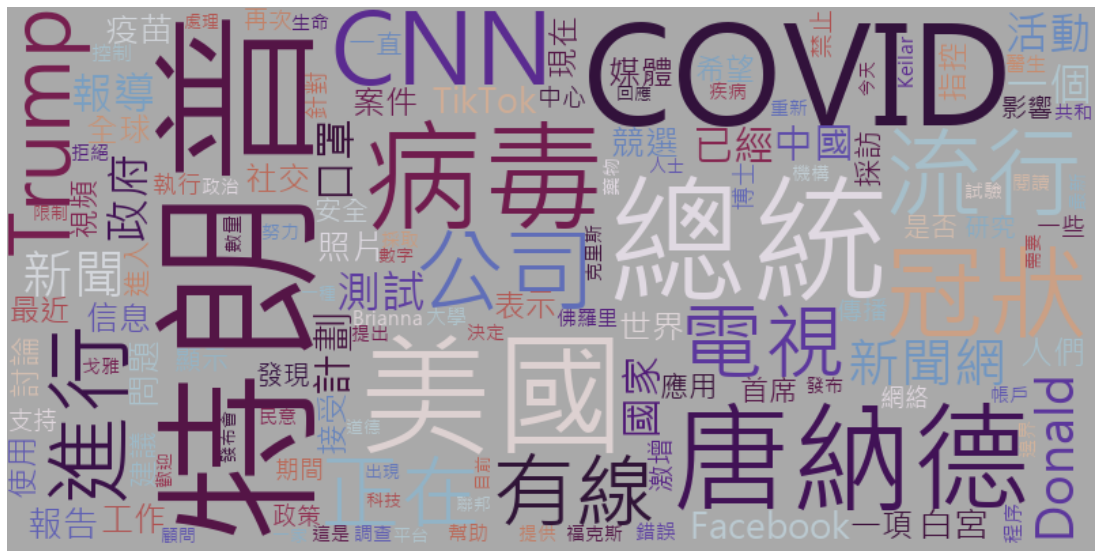

In [8]:
translator = Translator()
def get_translated_text(translated):
    return translated.text

articales_en_df_small['title_TW'] = articales_en_df_small['title'].apply(
    translator.translate,
    src='en',
    dest='zh-tw').apply(get_translated_text).str.strip()

articales_en_df_small['descr_TW'] = articales_en_df_small['description'].apply(
    translator.translate,
    src='en',
    dest='zh-tw').apply(get_translated_text).str.strip()


def jieba_processing_txt(text, stop_words_file):
    mywordlist = []
    seg_list = jieba.cut(text, cut_all=False)
    stopwords = [
        line.strip() for line in open(
            stop_words_file,
            encoding='utf-8').readlines()]
    for myword in seg_list:
        if len(myword.strip()) > 1 and myword not in stopwords:
            mywordlist.append(myword)
    return ' '.join(mywordlist)

font = 'msjh.ttf'
stop_words_file = 'stop_words_tw.txt'
wordcloud_en = WordCloud(
    min_font_size=10,
    width=800,
    height=400,
    collocations=False,
    background_color='DarkGrey',
    colormap='twilight',
    font_path=font).generate(
        jieba_processing_txt(
            articales_en_df_small['descr_TW'].str.cat( sep='.'), stop_words_file))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud_en, interpolation="bilinear")
plt.axis("off")
plt.show()